# CONTEXTUAL MINING OF TEXT

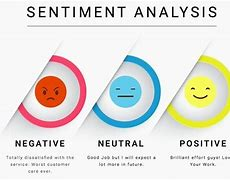

Sentiment analysis is a technique used to determine whether a given text expresses positive or negative sentiment. In this Jupyter notebook, we explore how to perform sentiment analysis on IMDB movie reviews using deep learning. The IMDB movie review dataset is a well-known benchmark dataset for sentiment analysis, containing thousands of movie reviews along with their corresponding sentiment labels. For the purpose of this project, I will obtain the data from Kaggle.

The objective of this project is to build a deep learning model that can classify movie reviews as positive or negative based on their text content. To accomplish this, we will preprocess the text data, create word embeddings, and build a neural network to classify the reviews. We will evaluate the model's performance using various evaluation metrics, including accuracy, precision, recall, and F1 score.

In this notebook, we will use Python and several popular deep learning libraries, including Keras, TensorFlow, and scikit-learn. We will walk through the entire process of data preprocessing, model training, and evaluation, and provide detailed explanations for each step. This notebook is designed for individuals who are interested in learning about sentiment analysis and deep learning, and who have a basic understanding of Python and machine learning concepts.

In [1]:
from google.colab import files
files.upload() #upload kaggle.json

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

!kaggle kernels list — user YOUR_USER — sort-by dateRun

!kaggle competitions download -c word2vec-nlp-tutorial

Saving kaggle.json to kaggle.json
kaggle.json
usage: kaggle
       [-h]
       [-v]
       {competitions,c,datasets,d,kernels,k,config}
       ...
kaggle: error: unrecognized arguments: — user YOUR_USER — sort-by dateRun
 70% 36.0M/51.7M [00:00<00:00, 115MB/s]
100% 51.7M/51.7M [00:00<00:00, 141MB/s]


In [2]:
!unzip word2vec-nlp-tutorial.zip

Archive:  word2vec-nlp-tutorial.zip
  inflating: labeledTrainData.tsv.zip  
  inflating: sampleSubmission.csv    
  inflating: testData.tsv.zip        
  inflating: unlabeledTrainData.tsv.zip  


In [3]:
!pip install --upgrade nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 29.6 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.7
    Uninstalling nltk-3.7:
      Successfully uninstalled nltk-3.7


In [4]:
import nltk
required_datasets = ['stopwords', 'punkt', 'averaged_perceptron_tagger', 'wordnet']

for dataset in required_datasets:
    nltk.download(dataset)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [5]:
import warnings
warnings.filterwarnings('ignore')

# Modules for data manipulation
import numpy as np
import pandas as pd
import re

# Modules for visualization
import matplotlib.pyplot as plt
import seaborn as sb

# Tools for preprocessing input data
from bs4 import BeautifulSoup
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Tools for creating ngrams and vectorizing input data
from gensim.models import Word2Vec, Phrases

# Tools for building a model
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tools for assessing the quality of model prediction
from sklearn.metrics import accuracy_score, confusion_matrix

In [6]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIG_SIZE = 16
LARGE_SIZE = 20

params = {
    'figure.figsize': (16, 8),
    'font.size': SMALL_SIZE,
    'xtick.labelsize': MEDIUM_SIZE,
    'ytick.labelsize': MEDIUM_SIZE,
    'legend.fontsize': BIG_SIZE,
    'figure.titlesize': LARGE_SIZE,
    'axes.titlesize': MEDIUM_SIZE,
    'axes.labelsize': BIG_SIZE
}
plt.rcParams.update(params)

This code allows you to set the default font sizes and other plot parameters for matplotlib, so that you don't have to specify them every time you create a new plot.

In [7]:
train_df = pd.read_csv('/content/labeledTrainData.tsv.zip', delimiter="\t")
test_df = pd.read_csv('/content/testData.tsv.zip', delimiter="\t")
submission_data = pd.read_csv('/content/unlabeledTrainData.tsv.zip', delimiter="\t", error_bad_lines=False)

b'Skipping line 43043: expected 2 fields, saw 3\n'


## EXPLORATORY DATA ANALYSIS

In [8]:
datasets = [train_df, submission_data, test_df]
titles = ['Labelled training data', 'Submission data', 'Test data']

for dataset, title in zip(datasets, titles):
    print()
    print(title)
    dataset.info()
    display(dataset.head())


Labelled training data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         25000 non-null  object
 1   sentiment  25000 non-null  int64 
 2   review     25000 non-null  object
dtypes: int64(1), object(2)
memory usage: 586.1+ KB


,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...



Submission data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49998 entries, 0 to 49997
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      49998 non-null  object
 1   review  49998 non-null  object
dtypes: object(2)
memory usage: 781.3+ KB


,id,review
0,9999_0,"Watching Time Chasers, it obvious that it was ..."
1,45057_0,I saw this film about 20 years ago and remembe...
2,15561_0,"Minor Spoilers<br /><br />In New York, Joan Ba..."
3,7161_0,I went to see this film with a great deal of e...
4,43971_0,"Yes, I agree with everyone on this site this m..."



Test data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      25000 non-null  object
 1   review  25000 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB


,id,review
0,12311_10,Naturally in a film who's main themes are of m...
1,8348_2,This movie is a disaster within a disaster fil...
2,5828_4,"All in all, this is a movie for kids. We saw i..."
3,7186_2,Afraid of the Dark left me with the impression...
4,12128_7,A very accurate depiction of small time mob li...


This code provides a quick way to get an overview of the structure and content of the  three datasets, which can be useful when working with data analysis or machine learning tasks.

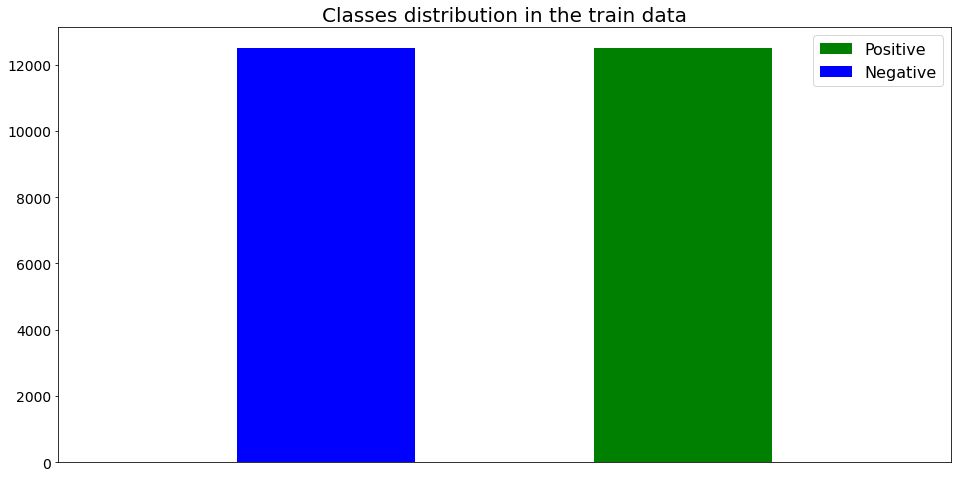

In [9]:
plt.hist(train_df[train_df.sentiment == 1].sentiment,
         bins=2, color='green', label='Positive')
plt.hist(train_df[train_df.sentiment == 0].sentiment,
         bins=2, color='blue', label='Negative')
plt.title('Classes distribution in the train data', fontsize=LARGE_SIZE)
plt.xticks([])
plt.xlim(-0.5, 2)
plt.legend()
plt.show()

The classes are evenly balanced. There is no need for resampling.

## DATA PREPROCESSING

In [10]:
REPLACE_WITH_SPACE = re.compile(r'[^A-Za-z\s]')
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def clean_review(raw_review: str) -> str:
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review, "lxml").get_text()
    # 2. Remove non-letters
    letters_only = REPLACE_WITH_SPACE.sub(" ", review_text)
    # 3. Convert to lower case
    lowercase_letters = letters_only.lower()
    return lowercase_letters

def lemmatize(tokens: list) -> list:
    # 1. Lemmatize
    tokens = list(map(lemmatizer.lemmatize, tokens))
    lemmatized_tokens = list(map(lambda x: lemmatizer.lemmatize(x, "v"), tokens))
    # 2. Remove stop words
    meaningful_words = list(filter(lambda x: not x in stop_words, lemmatized_tokens))
    return meaningful_words

def preprocess(review: str) -> list:
    # 1. Clean text
    review = clean_review(review)
    # 2. Split into individual words
    tokens = word_tokenize(review)
    # 3. Lemmatize
    lemmas = lemmatize(tokens)
    # 4. Join the words back into one string separated by space,
    # and return the result.
    return lemmas

In [11]:
%%time
all_reviews = np.array([], dtype=str)
for dataset in datasets:
    all_reviews = np.concatenate((all_reviews, dataset.review), axis=0)

## PARALLEL PROCESSING

import multiprocessing as mp

# Define the number of worker processes to use
num_workers = 4

def preprocess_parallel(reviews):
    with mp.Pool(num_workers) as p:
        return p.map(preprocess, reviews)

all_reviews = np.array(preprocess_parallel(all_reviews))

# If your computer has multiple cores, you could use the 
# multiprocessing module to parallelize the preprocessing of 
# the reviews. This could allow you to process multiple 
# reviews simultaneously and speed up the overall preprocessing time.

CPU times: user 3.41 s, sys: 929 ms, total: 4.34 s
Wall time: 4min 46s


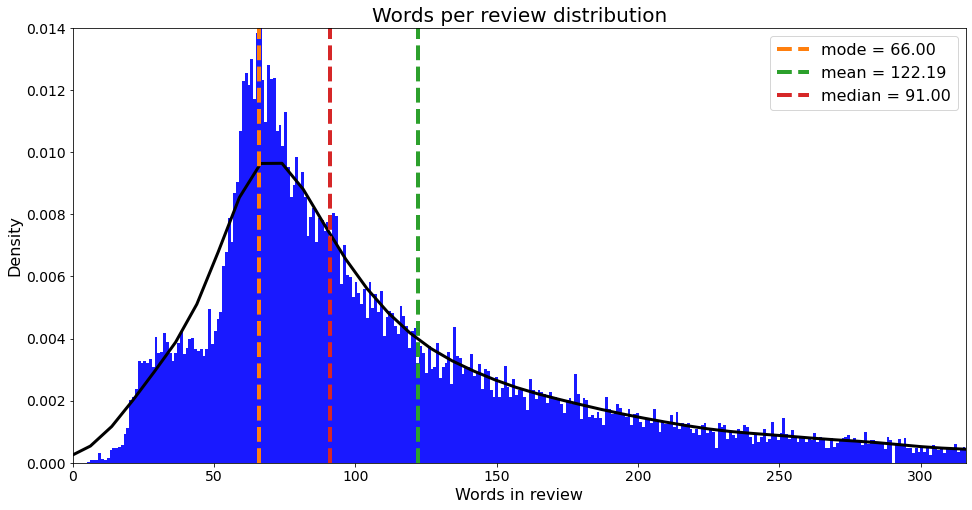

In [12]:
X_train_data = all_reviews[:train_df.shape[0]]
Y_train_data = train_df.sentiment.values
X_submission = all_reviews[25000:74999]

train_df['review_length'] = np.array(list(map(len, X_train_data)))
median = train_df['review_length'].median()
mean = train_df['review_length'].mean()
mode = train_df['review_length'].mode()[0]

fig, ax = plt.subplots()
sb.distplot(train_df['review_length'], bins=train_df['review_length'].max(),
            hist_kws={"alpha": 0.9, "color": "blue"}, ax=ax,
            kde_kws={"color": "black", 'linewidth': 3})
ax.set_xlim(left=0, right=np.percentile(train_df['review_length'], 95))
ax.set_xlabel('Words in review')
ymax = 0.014
plt.ylim(0, ymax)
ax.plot([mode, mode], [0, ymax], '--', label=f'mode = {mode:.2f}', linewidth=4)
ax.plot([mean, mean], [0, ymax], '--', label=f'mean = {mean:.2f}', linewidth=4)
ax.plot([median, median], [0, ymax], '--',
        label=f'median = {median:.2f}', linewidth=4)
ax.set_title('Words per review distribution', fontsize=20)
plt.legend()
plt.show()

The dustrubution number of words in each review appears to be skewed. However, we can use a model that is resistant to outliers e.g a Neural Net

In [13]:
%%time
bigrams = Phrases(sentences=all_reviews)

CPU times: user 23.1 s, sys: 320 ms, total: 23.4 s
Wall time: 23.7 s


In [14]:
%%time
trigrams = Phrases(sentences=bigrams[all_reviews])

CPU times: user 1min 8s, sys: 537 ms, total: 1min 9s
Wall time: 1min 14s


In [15]:
%%time
embedding_vector_size = 256
trigrams_model = Word2Vec(
    sentences = trigrams[bigrams[all_reviews]],
    size = embedding_vector_size,
    min_count=3, window=5, workers=8)

CPU times: user 14min 15s, sys: 2.78 s, total: 14min 18s
Wall time: 12min 2s


The code inside the block creates an object of the **Phrases** class from the `gensim` library. The `Phrases` class is used to train a bigram model on the input sentences, in this case all_reviews.

A **bigram model** is a statistical language model that tries to predict the next word in a sentence based on the current word. The Phrases class takes an array of sentences as input, `sentences=all_reviews`, and generates bigram phrases from the input sentences. These bigram phrases can then be used for various NLP tasks, such as text classification or information retrieval.

In [16]:
print("Vocabulary size:", len(trigrams_model.wv.vocab))

Vocabulary size: 91757


And now we can use gensim's **word2vec** model to build a word embedding. Also we can use the word2vec model to define most similar words, calculate diffence between the words, etc.

In [17]:
trigrams_model.wv.most_similar('galaxy')

[('continent', 0.8258012533187866),
 ('space_station', 0.8121803998947144),
 ('solar_system', 0.8064095973968506),
 ('deep_space', 0.8026586771011353),
 ('starship', 0.7941203117370605),
 ('wormhole', 0.7887479066848755),
 ('antarctica', 0.788183331489563),
 ('colony', 0.7706471681594849),
 ('sphere', 0.7685821056365967),
 ('outpost', 0.7654879093170166)]

In [18]:
trigrams_model.wv.doesnt_match(['galaxy', 'starship', 'planet', 'dog'])

'dog'

In [20]:
%%time
def vectorize_data(data, vocab: dict) -> list:
    print('Vectorize sentences...', end='\r')
    keys = list(vocab.keys())
    filter_unknown = lambda word: vocab.get(word, None) is not None
    encode = lambda review: list(map(keys.index, filter(filter_unknown, review)))
    vectorized = list(map(encode, data))
    print('Vectorize sentences... (done)')
    return vectorized

print('Convert sentences to sentences with ngrams...', end='\r')
X_data = trigrams[bigrams[X_train_data]]
print('Convert sentences to sentences with ngrams... (done)')
input_length = 150
X_pad = pad_sequences(
    sequences=vectorize_data(X_data, vocab=trigrams_model.wv.vocab),
    maxlen=input_length,
    padding='post')
print('Transform sentences to sequences... (done)')

Convert sentences to sentences with ngrams... (done)
Vectorize sentences... (done)
Transform sentences to sequences... (done)
CPU times: user 3min 51s, sys: 741 ms, total: 3min 51s
Wall time: 3min 54s


The code above is a function named `vectorize_data` that takes in two arguments: `data` and `vocab`. The purpose of the function is to convert the input `data` into numerical vectors, where each word in the `data` is represented by an index in the vocabulary `vocab`. The function does this by creating an **encoding function** that maps each word in the `data` to its corresponding index in the vocabulary. The function then applies the encoding function to each review in `data` to obtain a list of numerical vectors representing the reviews.

The code then applies the `vectorize_data` function to the `X_train_data` to obtain a list of numerical vectors representing the reviews with ngrams. Then, it uses the `pad_sequences` function from `keras.preprocessing.sequence` to pad the sequences of vectors to a fixed length of `input_length`. The padding is applied at the end of the sequences using the `post` argument. The result of the `pad_sequences` function is stored in `X_pad`, which is a matrix where each row represents a review in the training data and each column represents a word in the review. The X_pad matrix will be used as input to a neural network for training.

## DEEP LEARNING MODEL

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X_pad,
    Y_train_data,
    test_size=0.05,
    shuffle=True,
    random_state=42)

In [22]:
def build_model(embedding_matrix: np.ndarray, input_length: int):

    model = Sequential()
    model.add(Embedding(
        input_dim = embedding_matrix.shape[0],
        output_dim = embedding_matrix.shape[1], 
        input_length = input_length,
        weights = [embedding_matrix],
        trainable=False))
    model.add(Bidirectional(LSTM(128, recurrent_dropout=0.1)))
    model.add(Dropout(0.25))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    return model

model = build_model(
    embedding_matrix=trigrams_model.wv.vectors,
    input_length=input_length)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 256)          23489792  
                                                                 
 bidirectional (Bidirectiona  (None, 256)              394240    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                        

This is a neural network model for sequential data (such as text). The architecture consists of the following layers:

1. `Embedding` layer: This layer takes the input sequence of integer-encoded vocabulary and maps each integer to a vector of fixed size. This layer has `input_dim` input size (i.e., the size of the vocabulary) and `output_dim` output size (i.e., the size of the embedding vector). The `weights` parameter initializes the layer with pre-trained embedding weights, and `trainable` is set to `False` to keep the pre-trained weights fixed during training.

2. `Bidirectional` `LSTM` layer: This layer is a type of recurrent neural network layer that processes sequences by taking into account both past and future context. The `Bidirectional` wrapper processes the input sequence both forwards and backwards using two separate hidden state sequences. The layer has 128 hidden units, with a `recurrent_dropout` rate of 0.1 to prevent overfitting.

3. `Dropout` layer: This layer randomly drops out a fraction of the input units to prevent overfitting. In this case, 25% of the inputs are dropped out.

4. `Dense` layer: This is a fully connected layer with 256 units and a rectified linear unit (`relu`) activation function.

5. Another `Dropout` layer with a dropout rate of 30%.

6. Another `Dense` layer with 128 units and a `relu` activation function.

7. Another `Dropout` layer with a dropout rate of 30%.

8. Another `Dense` layer with 64 units and a `relu` activation function.

9. Another `Dropout` layer with a dropout rate of 30%.

10. `Dense` layer: This is the final output layer of the model with a single unit and a `sigmoid` activation function, which outputs the predicted probability of the input sequence belonging to a certain class (in this case, a binary classification of positive or negative sentiment).

The `summary` method of the model prints out a summary of the layer shapes and the number of trainable parameters in the model.

In [23]:
model.compile(
    loss="binary_crossentropy",
    optimizer='adam',
    metrics=['accuracy'])

history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    batch_size=100,
    epochs=20)

Epoch 1/20
238/238 [==============================] - 275s 1s/step - loss: 0.6553 - accuracy: 0.6091 - val_loss: 0.6996 - val_accuracy: 0.5504
Epoch 2/20
238/238 [==============================] - 257s 1s/step - loss: 0.5921 - accuracy: 0.6981 - val_loss: 0.5061 - val_accuracy: 0.7696
Epoch 3/20
238/238 [==============================] - 255s 1s/step - loss: 0.5006 - accuracy: 0.7624 - val_loss: 0.4866 - val_accuracy: 0.7720
Epoch 4/20
238/238 [==============================] - 257s 1s/step - loss: 0.4519 - accuracy: 0.7930 - val_loss: 0.4767 - val_accuracy: 0.7744
Epoch 5/20
238/238 [==============================] - 255s 1s/step - loss: 0.4053 - accuracy: 0.8196 - val_loss: 0.4781 - val_accuracy: 0.7648
Epoch 6/20
238/238 [==============================] - 255s 1s/step - loss: 0.3646 - accuracy: 0.8410 - val_loss: 0.4472 - val_accuracy: 0.8032
Epoch 7/20
238/238 [==============================] - 253s 1s/step - loss: 0.3218 - accuracy: 0.8647 - val_loss: 0.4401 - val_accuracy: 0.7992

The `model.compile` function is used to compile the model. It takes three arguments:

- `loss`: This is the loss function used to optimize the model. In this case, the loss function is "binary_crossentropy". This is used because this is a binary classification problem, where we want to predict either a positive or a negative sentiment.

- `optimizer`: This is the optimization algorithm used to update the weights of the model during training. In this case, it's the Adam optimizer, which is a popular optimization algorithm for deep learning models.

- `metrics`: This is a list of metrics to evaluate the model. In this case, the metric used is accuracy, which measures the proportion of correct predictions made by the model.

## MODEL EVALUATION

In [24]:
%%time
y_train_pred = np.round(model.predict(X_train))
y_test_pred = np.round(model.predict(X_test))

40/40 [==============================] - 3s 85ms/step
CPU times: user 1min 9s, sys: 284 ms, total: 1min 10s
Wall time: 1min 10s


In [ ]:
def plot_confusion_matrix(y_true, y_pred, ax, class_names, vmax=None,
                          normed=True, title='Confusion matrix'):
    matrix = confusion_matrix(y_true,y_pred)
    if normed:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    sb.heatmap(matrix, vmax=vmax, annot=True, square=True, ax=ax,
               cmap=plt.cm.Blues_r, cbar=False, linecolor='black',
               linewidths=1, xticklabels=class_names)
    ax.set_title(title, y=1.20, fontsize=16)
    ax.set_ylabel('True labels', fontsize=12)
    ax.set_xlabel('Predicted labels', y=1.10, fontsize=12)
    ax.set_yticklabels(class_names, rotation=0)

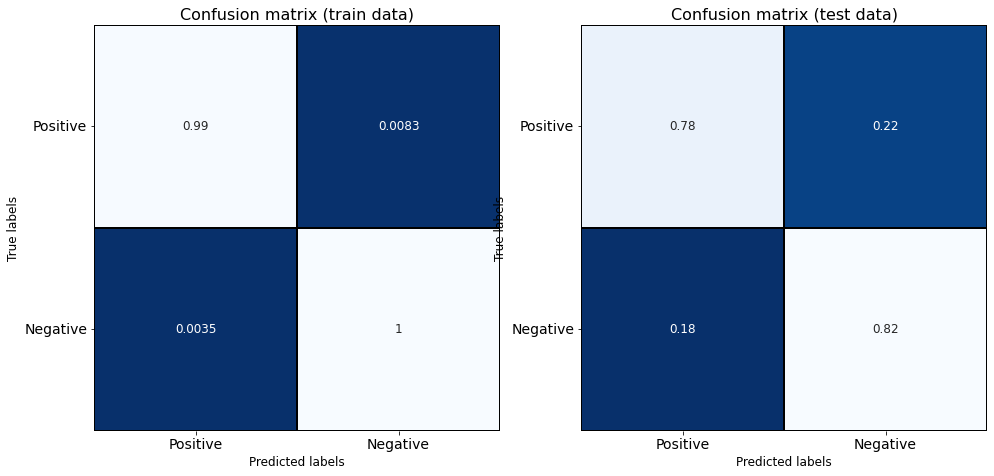

In [26]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2)
plot_confusion_matrix(y_train, y_train_pred, ax=axis1,
                      title='Confusion matrix (train data)',
                      class_names=['Positive', 'Negative'])
plot_confusion_matrix(y_test, y_test_pred, ax=axis2,
                      title='Confusion matrix (test data)',
                      class_names=['Positive', 'Negative'])

This code is a function that plots a **confusion matrix** to visualize the performance of a binary classification model. The function takes the following arguments:

- `y_true`: The true labels of the data
- `y_pred`: The predicted labels of the model
- `ax`: The subplot that the confusion matrix will be plotted on
- `class_names`: The names of the two classes in the binary classification problem
- `vmax`: The maximum value to be used in the color map. If set to `None`, the maximum value is automatically determined
- `normed`: A boolean value indicating whether the entries in the confusion matrix should be normalized or not
- `title`: The title of the plot

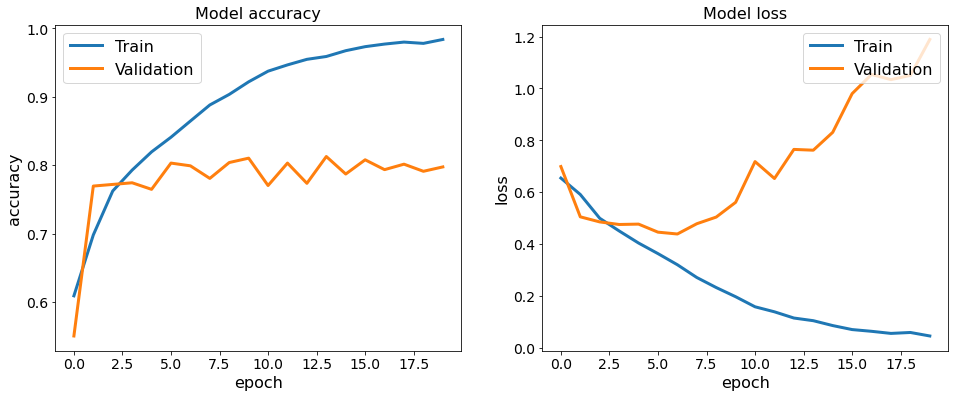

In [27]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

# summarize history for accuracy
axis1.plot(history.history['accuracy'], label='Train', linewidth=3)
axis1.plot(history.history['val_accuracy'], label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=16)
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='upper left')

# summarize history for loss
axis2.plot(history.history['loss'], label='Train', linewidth=3)
axis2.plot(history.history['val_loss'], label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=16)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.show()

In [28]:
# from tensorflow import keras

# SAVING THE MODEL
model.save('path/to/model.h5')

This code saves the model in HDF5 format. The saved model can be used later in other applications or in production.

You can load the model like so:

`loaded_model = keras.models.load_model('path/to/model.h5')`
